# Aula 17 - CNN + Transfer Learning

In [1]:
# Imports
import tensorflow as tf
import numpy as np

In [2]:
# Carregar o dataset
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1, 
    as_supervised=True
)

In [3]:
train_ds.shape

TensorShape([2569, 442, 1024, 3])

In [4]:
test_ds.shape

TensorShape([1101, 442, 1024, 3])

## Processar os dados

In [5]:
size = (150 , 150)

train_ds = tf.image.resize(train_ds, size)
test_ds = tf.image.resize(test_ds, size)

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [6]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Modelo "profundo" simples

In [7]:
# Import 
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Definir a arquitetura da CNN -> camada de extração de features
hand_model = Sequential()
hand_model.add( Rescaling(1./255, input_shape=(150, 150, 3)))

hand_model.add( layers.Conv2D(16, kernel_size=10, activation="relu") )
hand_model.add( layers.MaxPooling2D(3) ) 

hand_model.add( layers.Conv2D(32, kernel_size=8, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) ) 

hand_model.add( layers.Conv2D(32, kernel_size=6, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) ) 

# Definir a arquitetura da CNN -> camada de decisão (classificação)
hand_model.add( layers.Flatten() )
hand_model.add( layers.Dense(50, activation="relu") )
hand_model.add( layers.Dense(20, activation="relu") )
hand_model.add( layers.Dense(5, activation="sigmoid") )

# Compila o modelo
hand_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Definir a estratégia de Early Stopping
es = EarlyStopping(monitor="val_accuracy", 
                   patience=5, 
                   restore_best_weights=True)

# Treinamento do modelo 
with tf.device("/device:GPU:0"):
  hand_model.fit(train_ds, train_labels,
                 epochs=50,
                 validation_split=0.2,
                 batch_size=32,
                 callbacks=[es])

Epoch 1/50
65/65 [==============================] - 33s 502ms/step - loss: 1.5929 - accuracy: 0.2642 - val_loss: 1.5515 - val_accuracy: 0.3171
Epoch 2/50
65/65 [==============================] - 32s 499ms/step - loss: 1.4687 - accuracy: 0.3440 - val_loss: 1.6235 - val_accuracy: 0.3560
Epoch 3/50
65/65 [==============================] - 33s 506ms/step - loss: 1.3785 - accuracy: 0.4058 - val_loss: 1.2982 - val_accuracy: 0.4339
Epoch 4/50
65/65 [==============================] - 32s 486ms/step - loss: 1.2658 - accuracy: 0.4618 - val_loss: 1.2890 - val_accuracy: 0.4572
Epoch 5/50
65/65 [==============================] - 32s 484ms/step - loss: 1.1945 - accuracy: 0.4939 - val_loss: 1.2222 - val_accuracy: 0.4591
Epoch 6/50
65/65 [==============================] - 33s 510ms/step - loss: 1.1504 - accuracy: 0.5129 - val_loss: 1.1750 - val_accuracy: 0.5233
Epoch 7/50
65/65 [==============================] - 34s 517ms/step - loss: 1.0776 - accuracy: 0.5533 - val_loss: 1.2538 - val_accuracy: 0.4961

KeyboardInterrupt: 

In [ ]:
# Avaliação do modelo
loss, acc = hand_model.evaluate(test_ds, test_labels)

print(f"A loss do modelo é {loss:.2f} e a ACC é: {acc:.2f}")

35/35 [==============================] - 0s 13ms/step - loss: 0.6650 - accuracy: 0.7620
A loss do modelo é 0.67 e a ACC é: 0.76


In [ ]:
# Michel TODO - trazer a matriz de confusão e gráficos de loss/accuracy

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix 

def plot_confusion_matrix(y_test, y_pred):
  labels = list(map(np.argmax, y_test))
  labels_pred = list(map(np.argmax,y_pred))

  cf_matrix = confusion_matrix(labels, labels_pred)
  sns.heatmap(cf_matrix, annot=True)

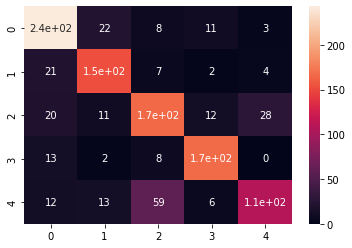

In [ ]:
pred = hand_model.predict(test_ds)
plot_confusion_matrix(test_labels, pred)

## Trabalhando com Transfer Learning do modelo VGG16

In [ ]:
# import 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocessa os dados de treinamento e teste 
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

# Importa o modelo de base, que será a VGG16 ***sem*** a camada de decisão

base_model = VGG16(weights = "imagenet", include_top= False,
                    input_shape=train_ds[0].shape)

# Usar os mesmos pesos da rede treinada (sem fine tunning)
base_model.trainable = False


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Observa a estrutura do modelo importado
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Adicionar a camada de decisão (classificação)

In [ ]:
from tensorflow.keras import layers, models

# Definir as camadas
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation = "relu")
dense_layer_2 = layers.Dense(20, activation = "relu")
prediction_layer = layers.Dense(5, activation = "softmax")

# Estabelece o modelo completo:
model = models.Sequential([
    base_model,               # A base CNN da VGG16
    flatten_layer,            # Achata as features que saem da VGG16 (base_model)
    dense_layer_1,            # 1 camada oculta fully connected
    dense_layer_2,            # 2 camada oculta fully connected
    prediction_layer          # Camada de saida, com 5 neuronios para classificação
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 50)                409650    
                                                                 
 dense_10 (Dense)            (None, 20)                1020      
                                                                 
 dense_11 (Dense)            (None, 5)                 105       
                                                                 
Total params: 15,125,463
Trainable params: 410,775
Non-trainable params: 14,714,688
_________________________________________________________________


### Treinamento do modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compila o novo modelo 
model.compile(
      optimizer = "adam",
      loss = "categorical_crossentropy",
      metrics = ["accuracy"]
)

# Define a estratégia de Early Stopping

es = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = 5, restore_best_weights= True)

# Treina o modelo
model.fit(train_ds,train_labels, epochs = 50, 
          validation_split= 0.2, batch_size=32,
          callbacks=[es])

Epoch 1/50
65/65 [==============================] - 10s 122ms/step - loss: 1.9418 - accuracy: 0.4959 - val_loss: 1.1351 - val_accuracy: 0.6167
Epoch 2/50
65/65 [==============================] - 6s 97ms/step - loss: 0.7320 - accuracy: 0.7392 - val_loss: 0.9085 - val_accuracy: 0.6693
Epoch 3/50
65/65 [==============================] - 6s 96ms/step - loss: 0.4540 - accuracy: 0.8311 - val_loss: 0.8981 - val_accuracy: 0.6693
Epoch 4/50
65/65 [==============================] - 6s 96ms/step - loss: 0.2833 - accuracy: 0.9041 - val_loss: 0.9411 - val_accuracy: 0.6848
Epoch 5/50
65/65 [==============================] - 6s 98ms/step - loss: 0.1950 - accuracy: 0.9377 - val_loss: 0.9511 - val_accuracy: 0.6984
Epoch 6/50
65/65 [==============================] - 6s 97ms/step - loss: 0.1369 - accuracy: 0.9616 - val_loss: 0.9807 - val_accuracy: 0.7023
Epoch 7/50
65/65 [==============================] - 6s 100ms/step - loss: 0.0944 - accuracy: 0.9776 - val_loss: 1.0073 - val_accuracy: 0.7062
Epoch 8/50

In [ ]:
# Avaliação do modelo
loss, acc = model.evaluate(test_ds, test_labels)

print(f"A loss do modelo é {loss:.2f} e a ACC é: {acc:.2f}")

35/35 [==============================] - 4s 108ms/step - loss: 0.0147 - accuracy: 0.9982
A loss do modelo é 0.01 e a ACC é: 1.00


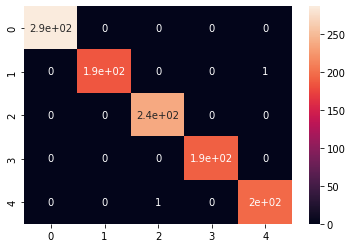

In [ ]:
pred = model.predict(test_ds)
plot_confusion_matrix(test_labels, pred)